Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 2 </h2>
    <h1> Ham o spam  </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Segundo Semestre 2022<br>    
        Fecha de entrega: Viernes 23 de septiembre 22.00 horas
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas. 

**IMPORTANTE**: 
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.


Utilizaremos una base de datos ubicada en Kaggle https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset que puedes encontrar igualmente en canvas como csv para descargar.

## Introducción

Nadie es inmune a recibir mensajes de Movistar o Entel ofreciéndonos planes. Abrir un mensaje para encontrarse con una hermosa sorpresa: es spam. 

Este es un problema a nivel mundial, tanto así que se han armado bases de datos con diferentes mensajes de texto recibidos por persona y si son considerados como spam o no (si no son spam se refiere a los mensajes como ham).

Utilizando la vectorización de frases y clusterizando estas, deberás predecir si esta es o no spam. Además, deberás obtener los índices de calidad de los clusters.

## 0. Setup

In [3]:
from IPython.display import clear_output

# !pip3 uninstall spacy
# !pip3 install spacy

!spacy download en_core_web_lg
clear_output()
print('Ahora debes reiniciar el entorno de ejecución y ejecutar a partir de la siguiente celda')

Ahora debes reiniciar el entorno de ejecución y ejecutar a partir de la siguiente celda


## 1. Importar librerías y descargar dataset
En esta tarea trabajaremos con la librería `spacy` y el pipeline `en_core_web_lg` el cual pesa más de 500 MB y contiene un vocabulario en inglés de más de medio millón de palabras. Cada una de estas palabras es representable a partir de un vector de 300 dimensiones que nos ayudarán en la tarea. Revisa la [documentación](https://spacy.io/api) documentación de la librería para saber más.

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
import spacy

nlp = spacy.load("en_core_web_lg")

### Leer dataset

In [5]:
url = 'spam.csv'
df = pd.read_csv(url, index_col=0, encoding="ISO-8859-1")
df

,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
v1,,,,
ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...
spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN


In [6]:
df.describe()

,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,50,12,6
unique,5169,43,10,5
top,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,30,3,2,2


## 2. Procesamiento de los datos (1 punto)

### 2.1 Eliminación de datos
Solamente analizaremos las columnas de si es o no spam y cuál es el mensaje. Elimina las columnas restantes y preprocesa las filas eliminando los valores nulos.

In [7]:
df['spam'] = df.index
df

,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
v1,,,,,
ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,ham
ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ham
spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,spam
ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,ham
ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,ham
...,...,...,...,...,...
spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN,spam
ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN,ham
ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN,ham


In [8]:
df_spam = df[['spam','v2']]
df_spam.dropna()

,spam,v2
v1,,
ham,ham,"Go until jurong point, crazy.. Available only ..."
ham,ham,Ok lar... Joking wif u oni...
spam,spam,Free entry in 2 a wkly comp to win FA Cup fina...
ham,ham,U dun say so early hor... U c already then say...
ham,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
spam,spam,This is the 2nd time we have tried 2 contact u...
ham,ham,Will Ì_ b going to esplanade fr home?
ham,ham,"Pity, * was in mood for that. So...any other s..."


### 2.2 Preprocesamiento de oraciones

Acá te damos el código para preprocesar un texto.

In [9]:
import string

all_stopwords = nlp.Defaults.stop_words

def remove_punctuation(text):
  text = [token for token in text if not token.is_punct]
  return text

def remove_stopwords(words):
  words = [word for word in words if not word in all_stopwords]
  return words

def lemmatize(words):
  words = [word.lemma_ for word in words]
  return words

def remove_non_alpha(words):
  words = [word for word in words if word.isalpha()]
  return words

def lower(words):
  words = [word.lower() for word in words]
  return words

def min_len(words, length=3):
  words = [word for word in words if len(word)>=length]
  return words

def preprocess(text):

  doc = nlp(text)
  tokens = remove_punctuation(doc)
  tokens = remove_stopwords(tokens)
  tokens = lemmatize(tokens)
  tokens = remove_non_alpha(tokens)
  tokens = lower(tokens)
  tokens = min_len(tokens, length=3)

  return ' '.join(tokens).strip()

# Este es un ejemplo para que veas si tu preprocesamiento funcionó.
new_text = preprocess("This is the 2nd time we have tried 2 contact...")
new_text

'this the time have try contact'

Preprocesa todos los mensajes utilizando el método preprocess y guárdalos en un dataframe.

In [10]:
text_list = []
for index, row in df_spam.iterrows():
  new_row = preprocess(row['v2'])
  mail_type = row['spam']
  row_list = [mail_type, new_row]
  text_list.append(row_list)
df_preprocess = pd.DataFrame(text_list, columns = ["type","message"])
df_preprocess

,type,message
0,ham,until jurong point crazy available only bugis ...
1,ham,lar joke wif oni
2,spam,free entry wkly comp win cup final tkts may te...
3,ham,dun say early hor already then say
4,ham,nah not think usf live around here though
...,...,...
5567,spam,this the time have try contact have win the po...
5568,ham,will esplanade home
5569,ham,pity mood for that any other suggestion
5570,ham,the guy some bitch but act like would interest...


Se eliminan los mensajes vacios.

In [11]:
df_preprocess = df_preprocess.dropna()
df_preprocess = df_preprocess[df_preprocess["message"] != '']
df_preprocess

,type,message
0,ham,until jurong point crazy available only bugis ...
1,ham,lar joke wif oni
2,spam,free entry wkly comp win cup final tkts may te...
3,ham,dun say early hor already then say
4,ham,nah not think usf live around here though
...,...,...
5567,spam,this the time have try contact have win the po...
5568,ham,will esplanade home
5569,ham,pity mood for that any other suggestion
5570,ham,the guy some bitch but act like would interest...


### 2.3 Vectorizar oraciones
En esta tarea, el vector de una oración será el promedio de los vectores de cada una de las palabras que fueron preprocesadas de la oración. La función presentada a continuación vectoriza una oración a partir de los vectores de las palabras.



In [12]:
def sentence_vector(text):
  text = nlp(text)
  vectores = []
  for t in text:
    t_vector = t.vector
    vectores.append(t_vector)
  return np.array(vectores).sum(axis=0)/len(vectores)

In [13]:
df_preprocess[["message"]]

,message
0,until jurong point crazy available only bugis ...
1,lar joke wif oni
2,free entry wkly comp win cup final tkts may te...
3,dun say early hor already then say
4,nah not think usf live around here though
...,...
5567,this the time have try contact have win the po...
5568,will esplanade home
5569,pity mood for that any other suggestion
5570,the guy some bitch but act like would interest...


In [15]:
vectores = []
for index, row in df_preprocess.iterrows():
  text = row["message"]
  vector = sentence_vector(text)
  vectores.append(vector)
# np.vstack(vectores)
# print(vector)

Se crea un array con los vectores procesados

In [16]:
vectores_tupla = tuple(vectores)
vstack_vectores = np.vstack(vectores)

In [72]:
df_array = pd.DataFrame(vstack_vectores)
vstack_vectores

array([[-0.09474561,  0.956886  , -1.245203  , ...,  0.8721586 ,
        -1.9395136 ,  0.6510226 ],
       [-0.22304   , -0.3103675 ,  0.613395  , ...,  1.0466975 ,
        -0.3638975 ,  0.464005  ],
       [ 0.30446714, -1.2143872 ,  1.0263379 , ..., -1.6731399 ,
         0.18420431, -0.60537285],
       ...,
       [-1.2304214 , -0.10015856, -1.8047985 , ..., -2.3744757 ,
        -3.5788844 ,  2.7823427 ],
       [-1.6322901 ,  0.25575548, -2.5586386 , ...,  0.74788886,
        -3.1058438 ,  0.7303979 ],
       [-0.6686466 ,  2.4182658 ,  1.9646494 , ..., -3.3921504 ,
        -5.2851615 ,  2.202806  ]], dtype=float32)

### 2.4. Obtener matriz de distancias


Obtén una forma de calcular una matriz que por cada par distintos de oraciones contenga la distancia euclidiana y coseno entre los vectores que representan a cada una. 

Hint: el método pairwise_distances de sklearn realiza esta operación eficientemente y no genera problemas de RAM.



In [18]:
from sklearn.metrics import pairwise_distances
matriz_euclidiana = pairwise_distances(vstack_vectores, vstack_vectores)
matriz_euclidiana[matriz_euclidiana == 0] = np.nan
matriz_euclidiana

array([[      nan, 22.287176, 21.584124, ..., 25.64222 , 17.197527,
        41.088566],
       [22.287176,       nan, 29.280226, ..., 36.931423, 31.36411 ,
        45.26217 ],
       [21.584124, 29.280226,       nan, ..., 29.595678, 25.300081,
        43.817024],
       ...,
       [25.64222 , 36.931423, 29.595678, ...,       nan, 20.358713,
        42.429527],
       [17.197527, 31.36411 , 25.300081, ..., 20.358713,       nan,
        43.578625],
       [41.088566, 45.26217 , 43.817024, ..., 42.429527, 43.578625,
              nan]], dtype=float32)

In [19]:
matriz_coseno = pairwise_distances(vstack_vectores, vstack_vectores, metric = "cosine")
matriz_coseno[matriz_coseno == 0] = np.nan

## 3. Clase AgglomerativeClustering (3 puntos)

Esta clase debe implemetar el algoritmo de clustering jerárquico aglomerativo. Para esto **debes** programar los siguientes métodos:


### **\_\_init\_\_**
Inicializa el algoritmo a partir de: la matriz `X` de los mensajes y la matriz de distancias. Considera además todas las variables que necesites a lo largo de la ejecución de tu algoritmo, se recomienda como mínimo:
*   Un contador que indique el nivel actual de aglomeración.
*   Un diccionario o lista que almacene los clusters en cada nivel de aglomeración. Inicialmente, en el nivel 0, existe un *cluster* por cada mensaje de `X`.
*   La matriz de distancia entre los *clusters* donde el elemento `matriz[id1][id2]` corresponde a la distancia entre los clusters con identificadores `id1` e `id2` respectivamente. 
*   Una copia de la matriz original X.


### **clusterize**
Ejecuta el método next_level hasta que solo existan dos *clusters*.

##### **next_level**
Equivale a realizar un nivel de aglomeración del algoritmo. A modo general deben:
1.   Obtener el par de *clusters* con menor distancia a partir de la matriz de distancias obtenida en 3.
2.   Unir ambos *clusters*.
3.   Guardar el nuevo conjunto de *clusters* correspondientes al nivel actual de aglomeración.
4.   Actualizar la matriz de distancias según el nuevo conjunto de *clusters*.

##### **update_matrix**
Actualiza la matriz de distancias dado un nuevo *cluster*. La distancia entre *clusters* debe poder calcularse según los siguientes enlaces (`linkage`) vistos en clases:
1.   **centroid**: distancia entre medias.
2.   **single**: simple.

<br>

---

**NOTA**: puedes entregarle los argumentos que quieras a estos métodos y tambien crear otros métodos que consideres pertinentes.

En base a lo visto en clases deberás implementar el algoritmo de clustering aglomerativo para agrupar los datos previamente preprocesados.

In [184]:
from urllib.parse import parse_qsl
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances_argmin_min


class Cluster(list):

  def __init__(self, *args):
        list.__init__(self, *args)
        self.vectors = []

class AgglomerativeClusteringTarea:

  def __init__(self, X, linkage="centroid", distance="Euclidean"):
    # Vectores de cada oracion.
    self.X = X.copy()
    # Linkage.
    self.linkage = linkage
    # Métrica de distancia.
    self.distance = distance
    # Nivel de aglomeracion.
    self.level = 0
    # Diccionarios de id de clusters, vectores dentro del cluster.
    self.clusters = {}
    i = 0
    for point in self.X:
      c = Cluster([point])
      c.vectors.append(i)
      self.clusters[i] = c
      i += 1

    self.copia_clusters = self.clusters
    # Matriz de distancias (obtén la matriz de distancias inicial)
    if self.distance == "Euclidean":
      self.matrix = pairwise_distances(self.X, self.X)
    else:
      self.matrix = pairwise_distances(self.X, self.X, metric = "cosine")

    # Convertir valores 0 a nan en matriz de distancia
    self.matrix[self.matrix == 0] = np.nan
    # Copia de la matriz de distancias original.
    self.original_matrix = self.matrix.copy()

  def clusterize(self):
    # self.next_level()
    while len(self.clusters) > 2:
      self.next_level()

  def next_level(self):
    print(f"Largo matriz de distancia: {len(self.matrix)}, Largo matriz de clusters: {len(self.clusters)}, Largo matriz de vectores: {len(self.X)}")
    # Obtén el par de clusters con menor distancia de la matriz de distancias.
    min_dist = np.nanmin(self.matrix)
    index = np.where(self.matrix == min_dist)
    index_v1, index_v2 = index[0][0], index[1][0]

    self.v1 = index_v1
    self.v2 = index_v2
    v1 = self.X[index_v1]
    v2 = self.X[index_v2]

    nuevo_cluster = Cluster([])

    # Crea un nuevo cluster a partir de los dos anteriores
    if index_v1 not in self.clusters.keys() and index_v2 not in self.clusters.keys():
      self.v1 = False
      self.v2 = False
      for id, cluster in self.clusters.items():
        if index_v1 in cluster.vectors:
            nuevo_cluster.append(cluster)
            nuevo_cluster.vectors = nuevo_cluster.vectors + cluster.vectors
            id_cluster_v1 = id
      for id, cluster in self.clusters.items():
        if index_v2 in cluster.vectors:
            nuevo_cluster.append(cluster)
            nuevo_cluster.vectors = nuevo_cluster.vectors + cluster.vectors
            id_cluster_v2 = id

    elif index_v1 not in self.clusters.keys() and index_v2 in self.clusters.keys():
      self.v1 = False
      for id, cluster in self.clusters.items():
        if index_v1 in cluster.vectors:
            nuevo_cluster.append(cluster)
            nuevo_cluster.vectors = cluster.vectors
            id_cluster_v1 = id
      nuevo_cluster.append(self.clusters[index_v2])
      nuevo_cluster.vectors.append(index_v2)

    elif index_v1 in self.clusters.keys() and index_v2 not in self.clusters.keys():
      self.v2 = False
      for id, cluster in self.clusters.items():
        if index_v2 in cluster.vectors:
            nuevo_cluster.append(cluster)
            nuevo_cluster.vectors = cluster.vectors
            id_cluster_v2 = id
      nuevo_cluster.append(self.clusters[index_v1])
      nuevo_cluster.vectors.append(index_v1)

    else:
      nuevo_cluster = Cluster([self.clusters[index_v1], self.clusters[index_v2]])
      nuevo_cluster.vectors.append(index_v1)
      nuevo_cluster.vectors.append(index_v2)

    # Elimina los dos clusters elegidos de los clusters actuales.
    if index_v1 in self.clusters.keys():
      del self.clusters[index_v1]
    else:
      del self.clusters[id_cluster_v1]
    if index_v2 in self.clusters.keys():
      del self.clusters[index_v2]
    elif id_cluster_v2 in self.clusters.keys():
      del self.clusters[id_cluster_v2]

    # El nuevo nivel tiene los clusters anteriores y la union de los dos clusters elegidos.
    self.clusters[index_v1] = nuevo_cluster

    # Elimina los dos clusters elegidos de la matriz de distancias.

    # Actualiza la matriz de distancias ingresando el nuevo cluster.
    self.update_matrix(nuevo_cluster)

    self.level += 1

# https://stackoverflow.com/questions/6340351/iterating-through-list-of-list-in-python
  def traverse(self, o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
      for value in o:
        for subvalue in self.traverse(value, tree_types):
          yield subvalue
    else:
      yield o
  
  def update_matrix(self, cluster):

    if self.linkage == "centroid":
      vectors_cluster = []
      for vector in self.traverse(cluster):
        vectors_cluster.append(vector)
      vector_mean = np.mean(vectors_cluster, axis=0)
      v_mean_array = [np.array(vector_mean)]
      if self.distance == "Euclidean": 
        distance = pairwise_distances_argmin_min(self.X, v_mean_array)[1]
      else:
        distance = pairwise_distances_argmin_min(self.X, v_mean_array, metric="cosine")[1]
      distance[distance == 0] = np.nan

      if self.v1:
        distance = np.delete(distance, self.v1, 0)
        self.matrix = np.delete(self.matrix, self.v1, 0)
        self.matrix = np.delete(self.matrix, self.v1, 1)
      if self.v2:
        self.matrix = np.delete(self.matrix, self.v2, 0)
        self.matrix = np.delete(self.matrix, self.v2, 1)
        distance = np.delete(distance, self.v2, 0)
      
      if self.v1 and self.v2:
        self.X = np.delete(self.X, self.v1, 0)
      elif self.v1:
        self.X = np.delete(self.X, self.v1, 0)
      elif self.v2:
        self.X = np.delete(self.X, self.v2, 0)

      self.matrix = np.r_[self.matrix, [distance]]
      distance = np.r_[distance, [np.nan]]
      self.matrix = np.hstack((self.matrix, np.atleast_2d(distance).T))
      # self.matrix = np.append(self.matrix, distance, axis=1)
      print(cluster.vectors)

    elif self.linkage == "single":
      vectors_cluster = []
      for vector in self.traverse(cluster):
        vectors_cluster.append(vector)
      dist = []
      for vector in vectors_cluster:
        v_array = [np.array(vector)]
        if self.distance == "Euclidean":
          distance = pairwise_distances_argmin_min(self.X, v_array)[1]
        else:
          distance = pairwise_distances_argmin_min(self.X, v_array, metric="cosine")[1]
        dist.append(distance)
        distance[distance == 0] = np.nan
      distance = min(distance)
      self.matrix = np.delete(self.matrix, self.v1, 0)
      self.matrix = np.delete(self.matrix, self.v2, 0)

      self.matrix = np.delete(self.matrix, self.v1, 1)
      self.matrix = np.delete(self.matrix, self.v2, 1)

model = AgglomerativeClusteringTarea(vstack_vectores)
model.clusterize()

Largo matriz de distancia: 5537, Largo matriz de clusters: 5537, Largo matriz de vectores: 5537
[1374, 2460]
Largo matriz de distancia: 5536, Largo matriz de clusters: 5536, Largo matriz de vectores: 5536
[2307, 2603]
Largo matriz de distancia: 5535, Largo matriz de clusters: 5535, Largo matriz de vectores: 5535
[2602, 2698]
Largo matriz de distancia: 5534, Largo matriz de clusters: 5534, Largo matriz de vectores: 5534
[2697, 2801]
Largo matriz de distancia: 5533, Largo matriz de clusters: 5533, Largo matriz de vectores: 5533
[2800, 5426]
Largo matriz de distancia: 5532, Largo matriz de clusters: 5532, Largo matriz de vectores: 5532
[309, 1558]
Largo matriz de distancia: 5531, Largo matriz de clusters: 5531, Largo matriz de vectores: 5531
[1530, 5328]
Largo matriz de distancia: 5530, Largo matriz de clusters: 5530, Largo matriz de vectores: 5530
[1556, 3876]
Largo matriz de distancia: 5529, Largo matriz de clusters: 5529, Largo matriz de vectores: 5529
[250, 4422]
Largo matriz de dista

ValueError: ignored

Se implemento el algoritmo AgglomerativeClusterring. Se creo la clase Cluster para poder checkear que vectores se encontraban en los clusters. Se intento implementar el linkage single y centroids. En el caso de centroids, existe un error con la modificación de la matriz de distancias.

Utiliza la clase para realizar la aglomeración con los datos preprocesados de spam:

In [168]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering()
model.fit(vstack_vectores)

AgglomerativeClustering()

# 4. Comparación con distintos parámetros (1 punto)

En esta parte deberás comparar distintas configuraciones de tu algoritmo de *clustering* y concluir cual de estas es la mejor.

Una forma de comparar *clusters* es a partir de su *silhouette score*. Este mide cuán similar es un objeto a su propio *cluster* (cohesión) en comparación con otros *clusters* (separación). Completa el siguiente código utilizando la función `silhouette_score` de `sklearn.metrics`.

NOTA: debes adaptar la estructura de clusters retornada por `AgglomerativeClustering` de tal forma que pueda ser utilizada como los `labels` que recibe `silhouette_score` ([documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)).

In [28]:
from sklearn.metrics import silhouette_score

def messages_silhouette_score(X, clusters):
  pass

Ahora realiza una busqueda de hiperparámetros para encontrar la configuración que retorne el mejor *silhouette_score*. Como mínimo debes probar todas las combinaciones posibles de los siguientes parámetros:

*   ***Linkage***: centroid y single.
*   ***Distance***: euclidean y cosine.

Hecho esto, responde las siguientes preguntas. Debes fundamentar todas tus respuestas con los resultados obtenidos en la búsqueda de hiperparametros.
1.   ¿Cual configuración fue la mejor? 
2.   ¿Que métrica de distancia da mejores resultados? (puedes comparar las métricas fijando un valor) 
3.   ¿Que relación observas entre el método de enlace y la métrica de distancia utilizada? **Justifica**.


# 5. Visualización (1 punto)

Los [dendrogramas](https://es.wikipedia.org/wiki/Dendrograma) son una forma muy útil de visualizar el funcionamiento de los algoritmos de *clustering* aglomerativo. Para completar esta sección debes generar un dendrograma a partir de tu mejor configuración de `AgglomerativeClustering`. Para esto debes utilizar la función `dendrogram` del módulo `cluster.hierarchy` de scipy.

<br>
<center>
<img src="https://docs.scipy.org/doc/scipy/_images/scipy-cluster-hierarchy-dendrogram-1_00.png" width="400"/>

Fuente: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

</center>

NOTA: Debes investigar que formato tiene la matriz `Z` (*linkage matrix*) que recibe `dendrogram` y adaptar el output de tu algoritmo acordemente. Está estrictamente prohibido obtener `Z` a partir de la función `linkage` del módulo `cluster.hierarchy`. Puedes modificar la clase `AgglomerativeClustering` si lo consideras necesario.

Si bien no se pudo implementar correctamente AgglomerativaClustering, de igual se forma se quizo visualizar los datos en un dendrograma. Se entiene que esta prohibido realizar esto por lo que no se espera puntaje y se mantiene comentado el código.

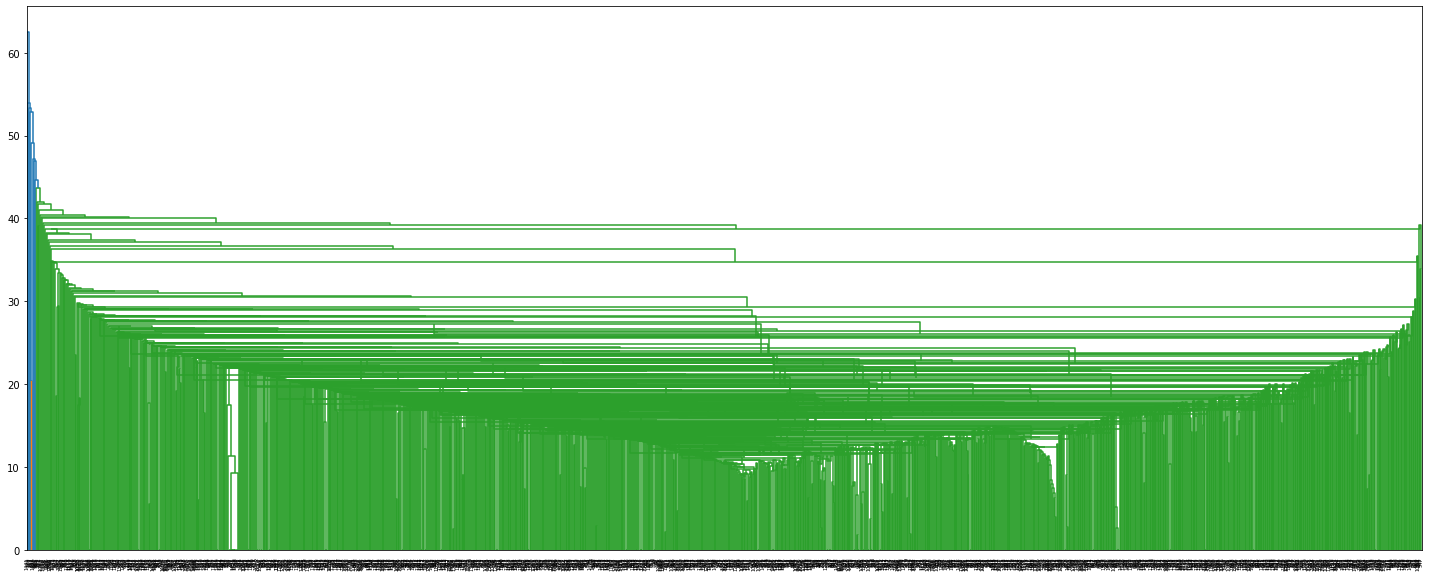

In [167]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.cluster import AgglomerativeClustering
# from matplotlib import pyplot as plt

# Z = linkage(vstack_vectores[:1500], "centroid")
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)
# plt.show()